# Disney Animated Movie Success

# Step 1: Import Necessary Libraries

In [97]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import lognorm, mannwhitneyu, chi2_contingency
from sklearn.linear_model import LinearRegression

# Step 2: Load the Datasets

In [99]:
# Load the datasets
df_adjusted_gross = pd.read_csv('C:/Users/sarah/Final Project/disney_movies_total_gross.csv')
df_runtime = pd.read_csv('C:/Users/sarah/Final Project/DisneyMoviesDatasetRunTime.csv')
df_movie_ratings = pd.read_csv('C:/Users/sarah/Final Project/CaseStudyData2024.csv', encoding='ISO-8859-1') # Utilize encoding to fix download issues
df_characters = pd.read_csv('C:/Users/sarah/Final Project/disney-characters_with_gender.csv')

# Display the first few rows of each dataset
print("Adjusted Gross Dataset:")
print(df_adjusted_gross.head())
print("\nRuntime Dataset:")
print(df_runtime.head())
print("\nMovie Ratings Dataset:")
print(df_movie_ratings.head())
print("\nCharacters Dataset:")
print(df_characters.head())

Adjusted Gross Dataset:
   index                      movie_title  release_date      genre  \
0      0  Snow White and the Seven Dwarfs  Dec 21, 1937    Musical   
1      1                        Pinocchio   Feb 9, 1940  Adventure   
2      2                         Fantasia  Nov 13, 1940    Musical   
3      3                Song of the South  Nov 12, 1946  Adventure   
4      4                       Cinderella  Feb 15, 1950      Drama   

  MPAA_rating   total_gross inflation_adjusted_gross  
0           G  $184,925,485           $5,228,953,251  
1           G   $84,300,000           $2,188,229,052  
2           G   $83,320,000           $2,187,090,808  
3           G   $65,000,000           $1,078,510,579  
4           G   $85,000,000             $920,608,730  

Runtime Dataset:
   Unnamed: 0                            title       Production company  \
0           0          Academy Award Review of  Walt Disney Productions   
1           1  Snow White and the Seven Dwarfs  Walt Disn

# Step 3: Data Cleaning

In [101]:
# Merge datasets
# Merge the datasets on 'movie_title' or 'film_title'
df_merged = pd.merge(df_adjusted_gross, df_runtime, left_on="movie_title", right_on="title", how="inner")
df_merged = pd.merge(df_merged, df_movie_ratings, left_on="movie_title", right_on="film_title", how="inner")
df_merged = pd.merge(df_merged, df_characters, left_on="movie_title", right_on="movie_title", how="inner")

# Clean the 'Budget' column (remove dollar signs, commas, and convert to numeric)
df_merged['Budget'] = df_merged['Budget'].replace({
    r'\$': '',           # Remove dollar sign
    r',': '',            # Remove commas
    r'million': '',      # Remove the word 'million'
    r'billion': ''       # Remove the word 'billion'
}, regex=True)
df_merged['Budget'] = pd.to_numeric(df_merged['Budget'], errors='coerce')  # Convert to numeric

# Clean 'inflation_adjusted_gross' column 
df_merged['inflation_adjusted_gross'] = df_merged['inflation_adjusted_gross'].replace({
    r'\$': '',           # Remove dollar sign
    r',': '',            # Remove commas
    r'million': '',      # Remove the word 'million'
    r'billion': ''       # Remove the word 'billion'
}, regex=True)
df_merged['inflation_adjusted_gross'] = pd.to_numeric(df_merged['inflation_adjusted_gross'], errors='coerce')  # Convert to numeric

# Clean 'rotten_tomatoes' column by removing '%' and converting to numeric
df_merged['rotten_tomatoes'] = df_merged['rotten_tomatoes'].replace({
    r'%': ''             # Remove percentage sign
}, regex=True)
df_merged['rotten_tomatoes'] = pd.to_numeric(df_merged['rotten_tomatoes'], errors='coerce')

# Fill missing values for 'Budget' with median, 'imdb' with median, and 'hero_gender' with 'Unknown'
df_merged['Budget'] = df_merged['Budget'].fillna(df_merged['Budget'].median())
df_merged['imdb'] = df_merged['imdb'].fillna(df_merged['imdb'].median())
df_merged['hero_gender'] = df_merged['hero_gender'].fillna('Unknown')

# Filter the merged DataFrame to only include movies that are in the 'df_characters' dataset
# Filtered this way to help focus on animated films
df_merged_filtered = df_merged[df_merged['movie_title'].isin(df_characters['movie_title'])]

# Display the filtered DataFrame
print(f"\nFiltered DataFrame with {len(df_merged_filtered)} rows:")
print(df_merged_filtered.head())


Filtered DataFrame with 46 rows:
   index_x         movie_title release_date_x      genre MPAA_rating  \
0        4          Cinderella   Feb 15, 1950      Drama           G   
1        4          Cinderella   Feb 15, 1950      Drama           G   
2       13     The Jungle Book   Oct 18, 1967    Musical   Not Rated   
3       13     The Jungle Book   Oct 18, 1967    Musical   Not Rated   
4       83  The Little Mermaid   Nov 15, 1989  Adventure           G   

    total_gross  inflation_adjusted_gross  Unnamed: 0               title  \
0   $85,000,000                 920608730          16          Cinderella   
1   $85,000,000                 920608730         374          Cinderella   
2  $141,843,000                 789612346          84     The Jungle Book   
3  $141,843,000                 789612346         382     The Jungle Book   
4  $111,543,479                 223726012         170  The Little Mermaid   

                                  Production company  ...  \
0        

# Step 4: Descriptive Statistics

In [103]:
# Variables to analyze
variables = ['Budget', 'inflation_adjusted_gross', 'imdb', 'rotten_tomatoes', 'Running time (int)']

# Descriptive statistics for each of these variables
for var in variables:
    print(f"\nDescriptive Statistics for {var}:")
    print(df_merged_filtered[var].describe())  # This includes count, mean, std, min, 25%, 50%, 75%, max


Descriptive Statistics for Budget:
count     46.000000
mean      89.973913
std       59.582210
min        2.900000
25%       45.000000
50%       90.000000
75%      125.000000
max      260.000000
Name: Budget, dtype: float64

Descriptive Statistics for inflation_adjusted_gross:
count    4.600000e+01
mean     3.483875e+08
std      2.407007e+08
min      5.518914e+07
25%      1.933303e+08
50%      2.791356e+08
75%      4.352262e+08
max      9.206087e+08
Name: inflation_adjusted_gross, dtype: float64

Descriptive Statistics for imdb:
count    46.000000
mean      7.386957
std       0.685276
min       5.300000
25%       6.900000
50%       7.400000
75%       8.000000
max       8.500000
Name: imdb, dtype: float64

Descriptive Statistics for rotten_tomatoes:
count    46.000000
mean     82.934783
std      16.745682
min      37.000000
25%      84.000000
50%      89.000000
75%      94.000000
max      98.000000
Name: rotten_tomatoes, dtype: float64

Descriptive Statistics for Running time (int):
co

# Step 5: Visualizations

## Histograms and Boxplots

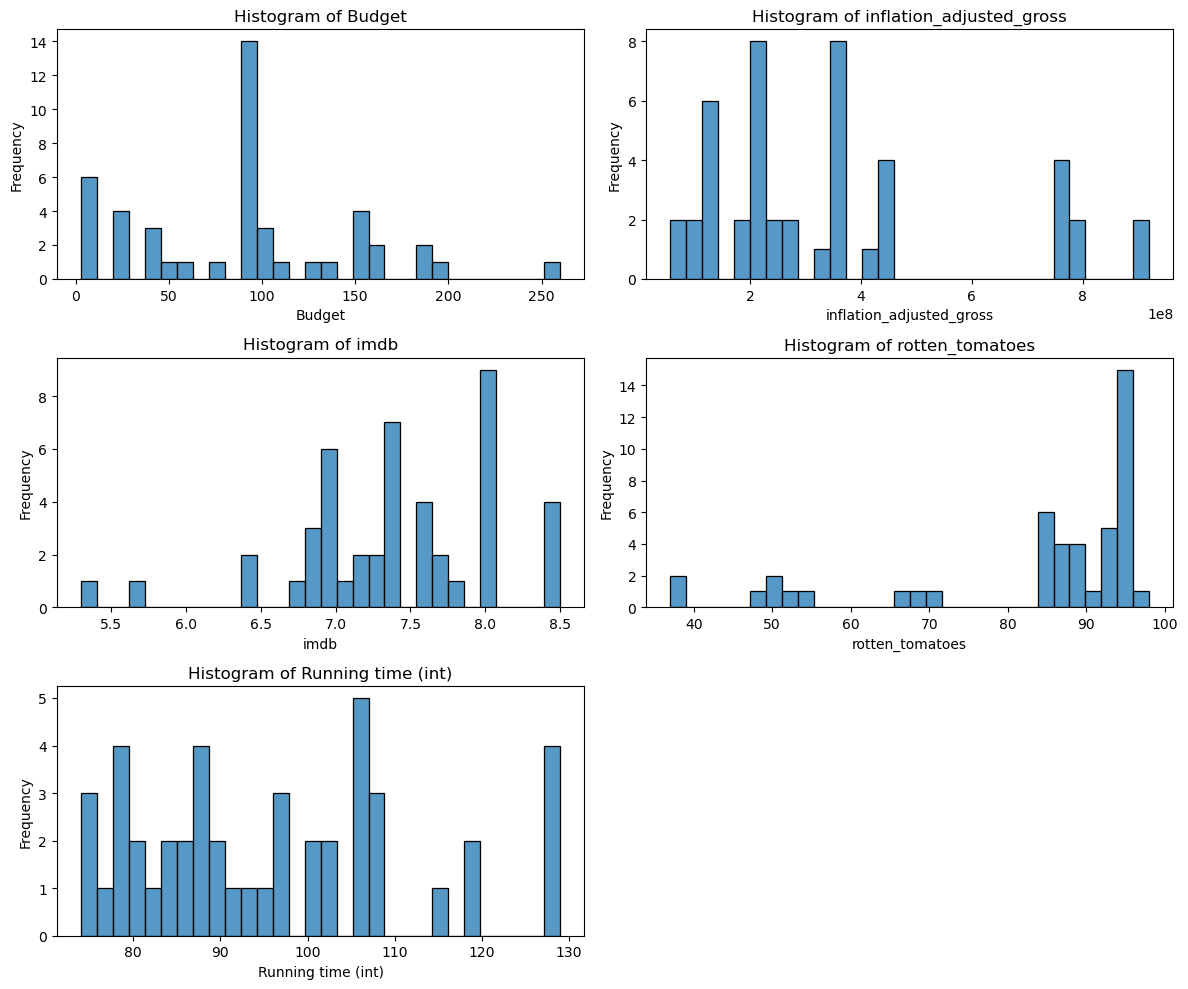

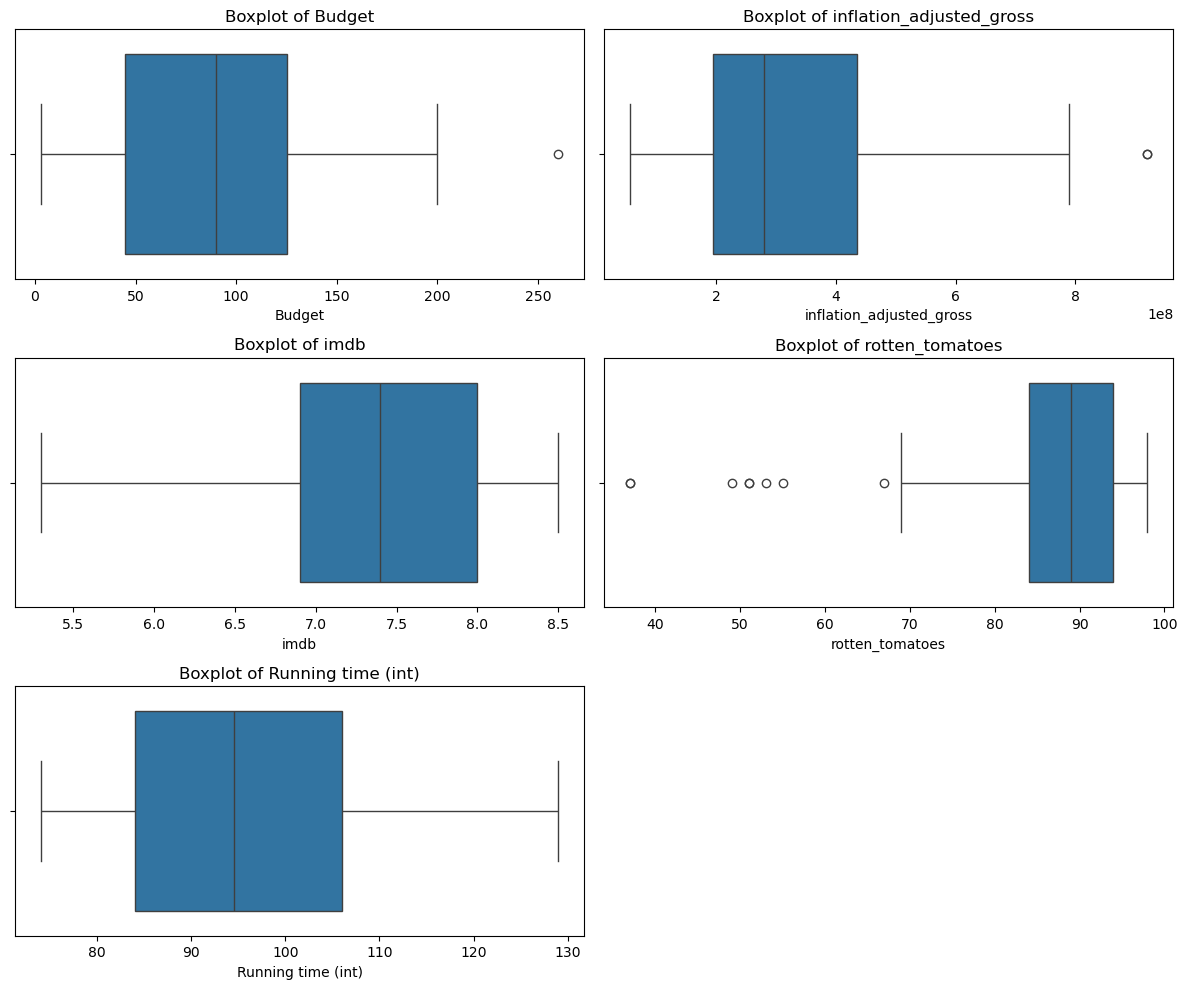

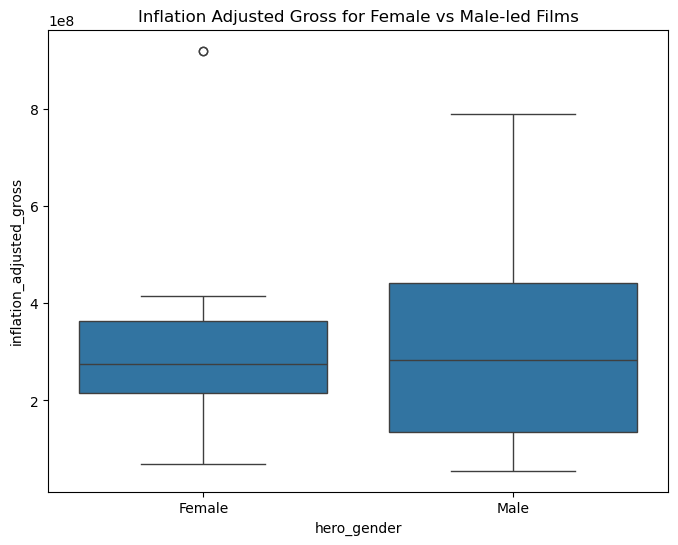

In [106]:
# Plot histograms for each of the variables
plt.figure(figsize=(12, 10))

for i, var in enumerate(variables, 1):
    plt.subplot(3, 2, i)  # 3 rows, 2 columns of subplots
    sns.histplot(df_merged_filtered[var], kde=False, bins=30)  # Adjust the bins as necessary
    plt.title(f'Histogram of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Boxplots for each variable to check for outliers
plt.figure(figsize=(12, 10))

for i, var in enumerate(variables, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x=df_merged_filtered[var])
    plt.title(f'Boxplot of {var}')
    plt.xlabel(var)

plt.tight_layout()
plt.show()

# Boxplot comparing inflation-adjusted gross for female vs male-led films
plt.figure(figsize=(8, 6))
sns.boxplot(x='hero_gender', y='inflation_adjusted_gross', data=df_merged_filtered)
plt.title('Inflation Adjusted Gross for Female vs Male-led Films')
plt.xticks(ticks=[0, 1], labels=['Female', 'Male'])
plt.show()

## PMF (Probability Mass Function) 

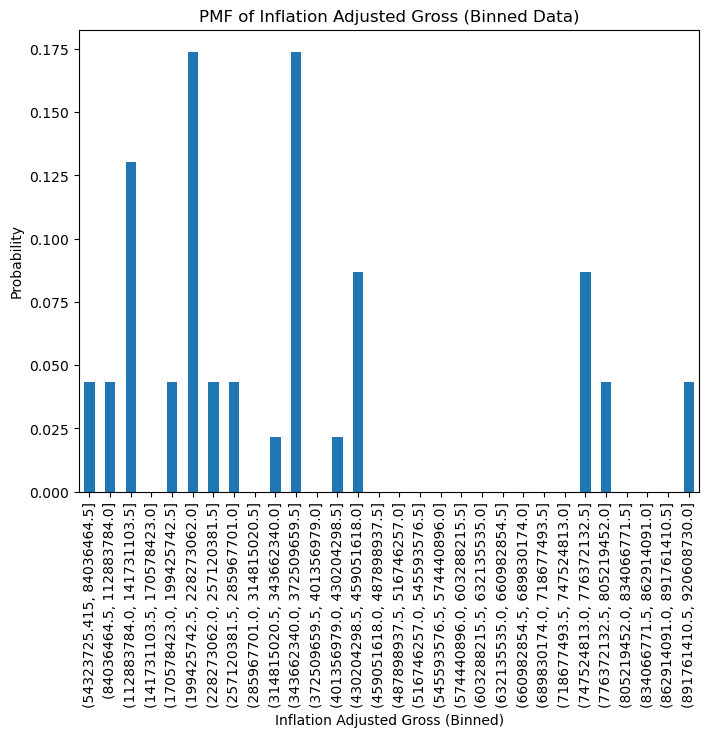

In [108]:
# Create a PMF for 'inflation_adjusted_gross' (using binned data for discreteness)
plt.figure(figsize=(8, 6))
df_merged_filtered['inflation_adjusted_gross_binned'] = pd.cut(df_merged_filtered['inflation_adjusted_gross'], bins=30)

# Plot the PMF for the binned 'inflation_adjusted_gross'
df_merged_filtered['inflation_adjusted_gross_binned'].value_counts(normalize=True).sort_index().plot(kind='bar')
plt.title('PMF of Inflation Adjusted Gross (Binned Data)')
plt.xlabel('Inflation Adjusted Gross (Binned)')
plt.ylabel('Probability')
plt.show()

## CDF (Cumulative Distribution Function)

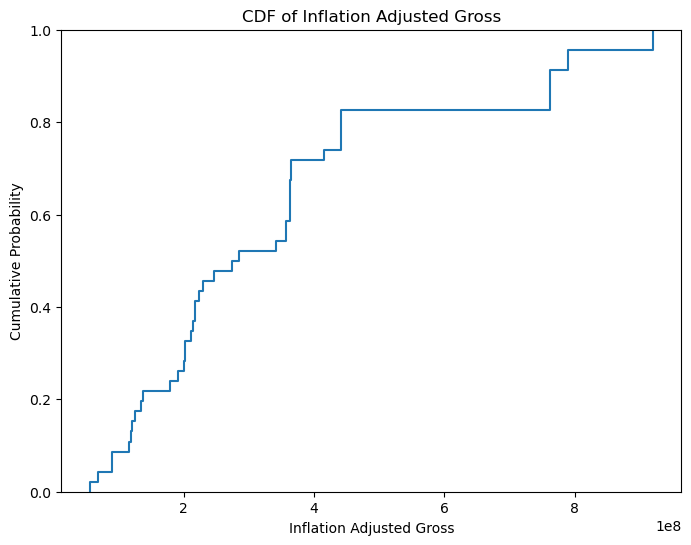

In [110]:
# Plot CDF for inflation_adjusted_gross
plt.figure(figsize=(8, 6))
sns.ecdfplot(df_merged_filtered['inflation_adjusted_gross'].dropna())
plt.title('CDF of Inflation Adjusted Gross')
plt.xlabel('Inflation Adjusted Gross')
plt.ylabel('Cumulative Probability')
plt.show()

## Log-Normal Distribution

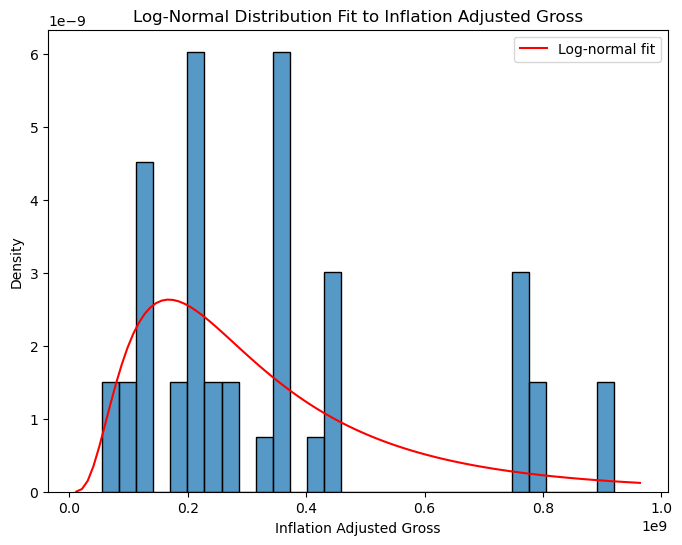

In [136]:
# Log-Normal Distribution
shape, loc, scale = lognorm.fit(df_merged_filtered['inflation_adjusted_gross'].dropna(), floc=0)

# Plot the Fit
plt.figure(figsize=(8, 6))
sns.histplot(df_merged_filtered['inflation_adjusted_gross'].dropna(), kde=False, bins=30, stat='density')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = lognorm.pdf(x, shape, loc, scale)
plt.plot(x, y, 'r-', label='Log-normal fit')
plt.title('Log-Normal Distribution Fit to Inflation Adjusted Gross')
plt.xlabel('Inflation Adjusted Gross')
plt.ylabel('Density')
plt.legend()
plt.show()

## Scatterplots

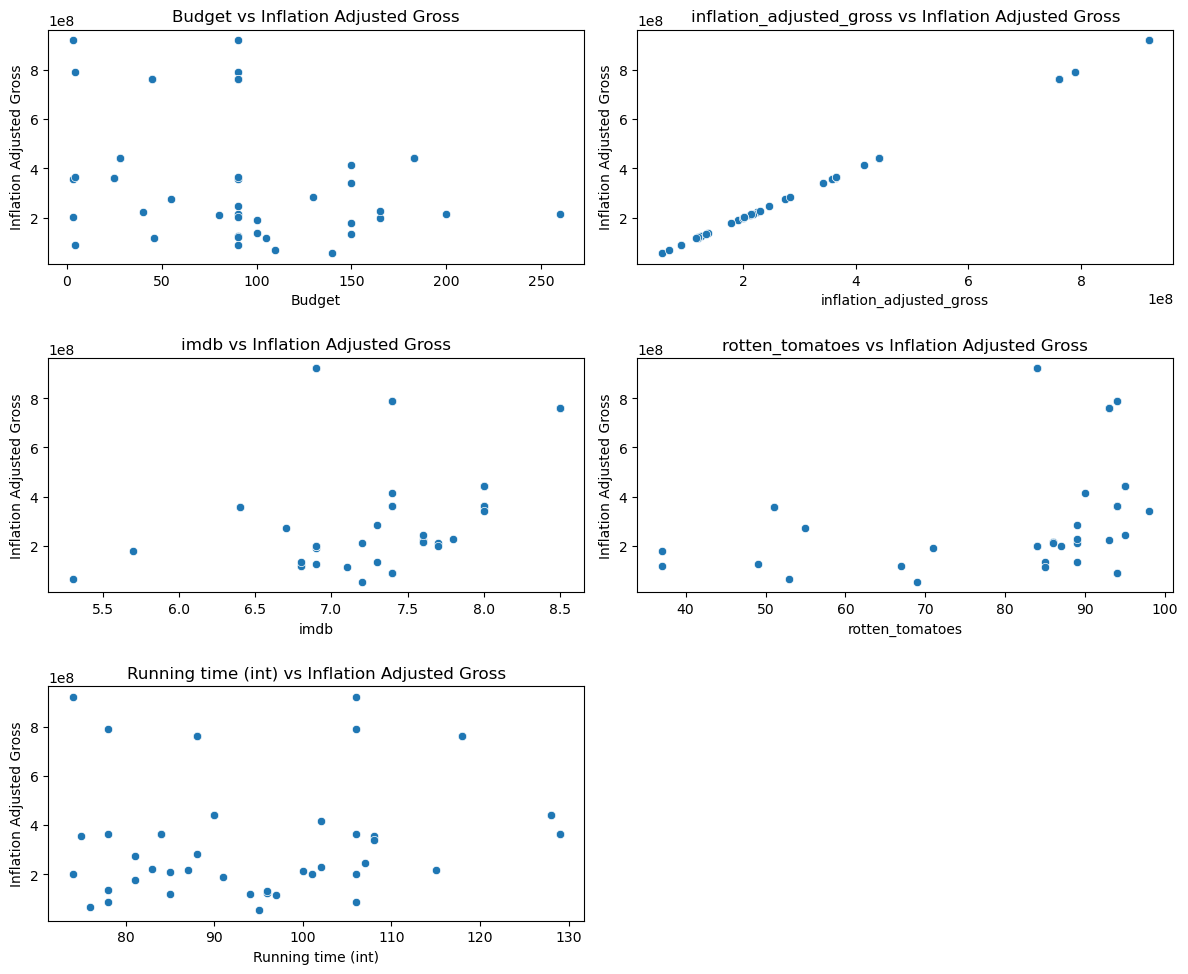

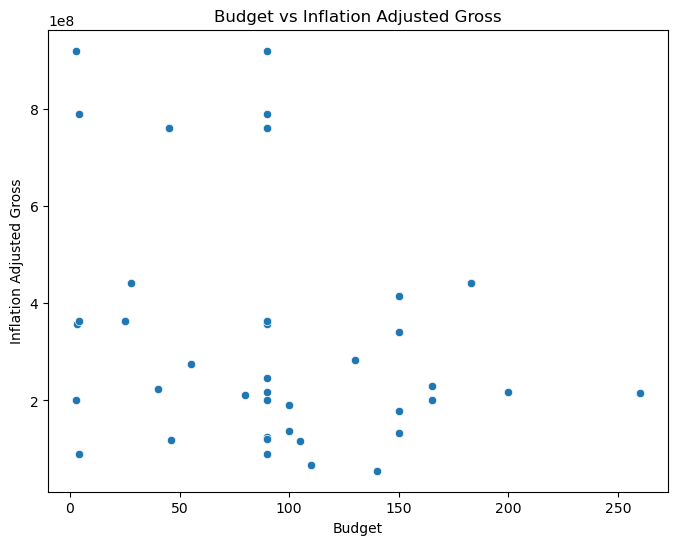

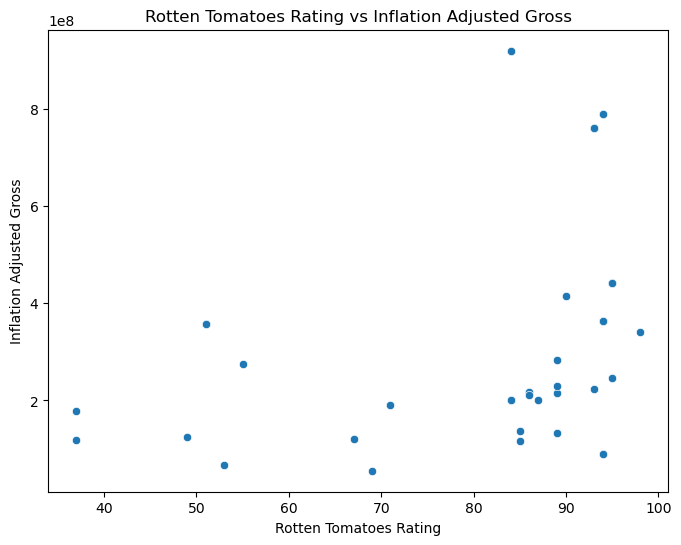

In [138]:
# # Create scatter plots for each of the variables to explore relationships with inflation_adjusted_gross
plt.figure(figsize=(12, 10))

# Loop through the variables and plot a scatterplot for each one against inflation_adjusted_gross
for i, var in enumerate(variables, 1):
    plt.subplot(3, 2, i)  # 3 rows, 2 columns of subplots
    sns.scatterplot(x=df_merged_filtered[var], y=df_merged_filtered['inflation_adjusted_gross'])
    plt.title(f'{var} vs Inflation Adjusted Gross')
    plt.xlabel(var)
    plt.ylabel('Inflation Adjusted Gross')

plt.tight_layout()
plt.show()

# Scatter plot for Budget vs inflation_adjusted_gross
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Budget', y='inflation_adjusted_gross', data=df_merged_filtered)
plt.title('Budget vs Inflation Adjusted Gross')
plt.xlabel('Budget')
plt.ylabel('Inflation Adjusted Gross')
plt.show()

# Scatter plot for Rotten Tomatoes vs inflation_adjusted_gross
plt.figure(figsize=(8, 6))
sns.scatterplot(x='rotten_tomatoes', y='inflation_adjusted_gross', data=df_merged_filtered)
plt.title('Rotten Tomatoes Rating vs Inflation Adjusted Gross')
plt.xlabel('Rotten Tomatoes Rating')
plt.ylabel('Inflation Adjusted Gross')
plt.show()

# Step 6: Regression Analysis

Intercept: -588367810.0871035
Coefficients: [-1.12422381e+06  1.28184338e+08  1.09741607e+06]


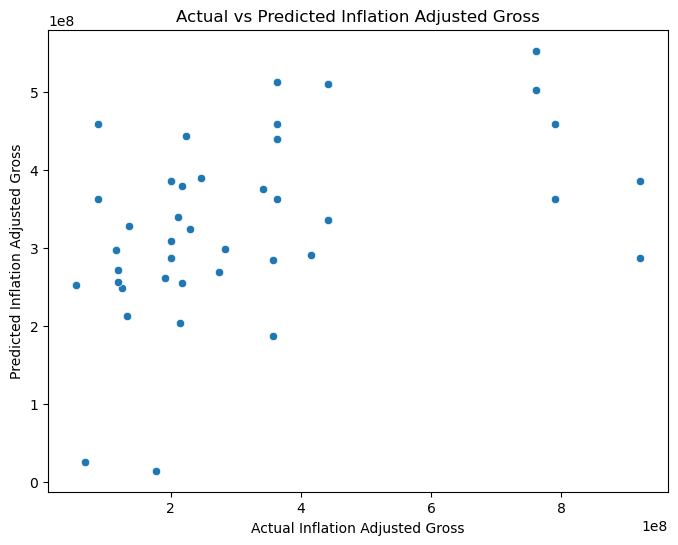

In [118]:
# Regression analysis - Predict inflation_adjusted_gross using Budget, imdb, and rotten_tomatoes
X = df_merged_filtered[['Budget', 'imdb', 'rotten_tomatoes']]  # Independent variables
y = df_merged_filtered['inflation_adjusted_gross']  # Dependent variable

# Fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Print the coefficients and intercept
print(f"Intercept: {model.intercept_}")
print(f"Coefficients: {model.coef_}")

# Predict using the model
y_pred = model.predict(X)

# Plot actual vs predicted inflation_adjusted_gross
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y, y=y_pred)
plt.title('Actual vs Predicted Inflation Adjusted Gross')
plt.xlabel('Actual Inflation Adjusted Gross')
plt.ylabel('Predicted Inflation Adjusted Gross')
plt.show()